# MSM of Brownian dynamics simulations of diffusion on a 1D surface
In this example we use data from a model potential in one dimension. The data is clustered by simply binning the values of the coordinate *x* and the resulting bins are used as MSM microstates.

 We start by importing the libraries needed for this example:

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import time
import itertools
import h5py
import numpy as np
from scipy.stats import norm
from scipy.stats import expon
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

#### Discretization

We load the trajectory data generated by Brownian Dynamics simulations.

In [2]:
h5file = "data/cossio_kl0_Dx1_Dq1.h5"
f = h5py.File(h5file, 'r')
data = np.array(f['data'])
f.close()

Text(0.5, 0, 'time')

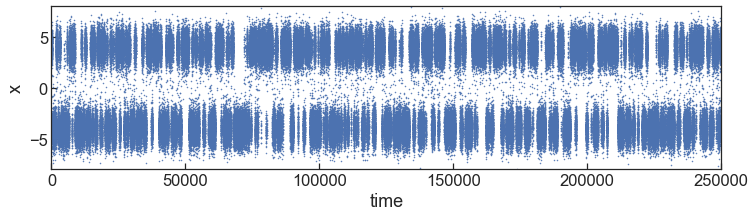

In [5]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(data[:,0],data[:,1],'.', markersize=1)
ax.set_ylim(-8,8)
ax.set_xlim(0,250000)
ax.set_ylabel('x')
ax.set_xlabel('time')

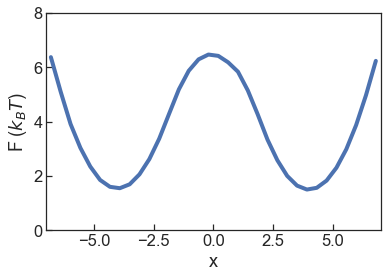

In [24]:
fig, ax = plt.subplots(figsize=(6,4))
hist, bin_edges = np.histogram(data[:,1], bins=np.linspace(-7,7,35),\
                               density=True)
bin_centers = [0.5*(bin_edges[i]+bin_edges[i+1]) \
               for i in range(len(bin_edges)-1)]
ax.plot(bin_centers, -np.log(hist), lw=4)
ax.set_xlim(-7,7)
ax.set_ylim(0,8)
ax.set_xlabel('x')
_ = ax.set_ylabel('F ($k_BT$)')

Now we discretize the trajectory using the states obtained from making a grid on the diffusion of the molecule.

In [14]:
assigned_trj = list(np.digitize(data[:,1],bins=bin_edges))

Text(0.5, 0, 'time')

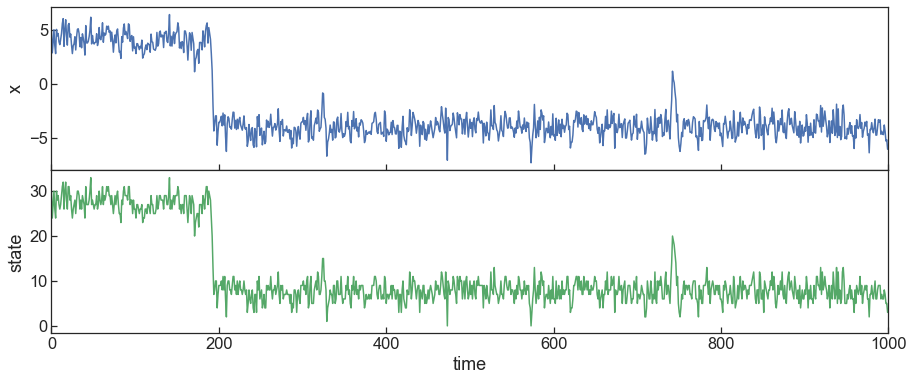

In [18]:
fig,ax=plt.subplots(2,1,figsize=(15,6), sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
ax[0].plot(range(0,len(data[:,1][:1000])),data[:,1][:1000])
ax[1].plot(range(0,len(assigned_trj[:1000])),assigned_trj[:1000],color="g")
ax[0].set_xlim(0,1000)
ax[0].set_ylabel('x')
ax[1].set_ylabel("state")
ax[1].set_xlabel("time")

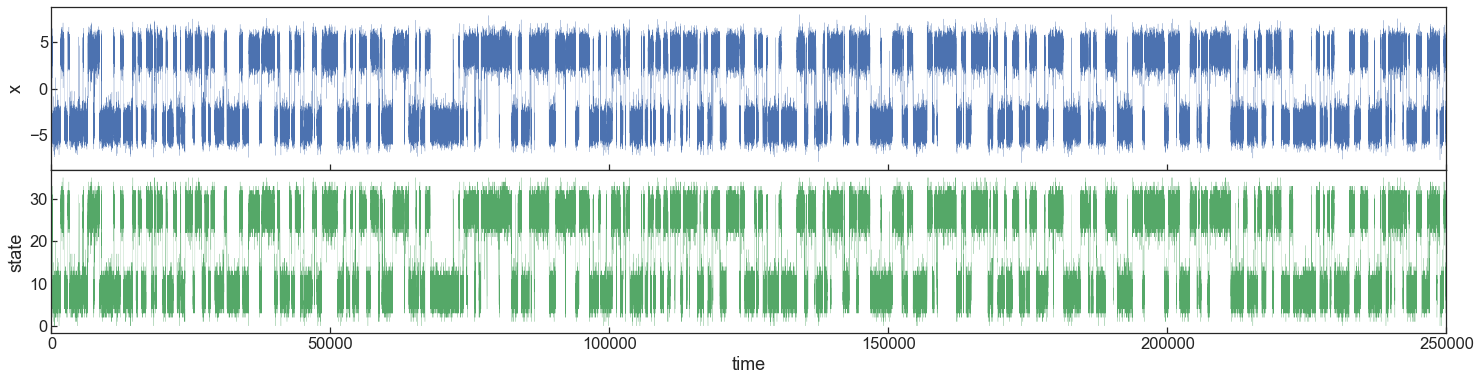

In [27]:
fig,ax = plt.subplots(2,1,figsize=(25,6), sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
ax[0].plot(range(0,len(data[:,1])),data[:,1], lw=0.2)
ax[1].plot(range(0,len(assigned_trj)),assigned_trj,color="g", lw=0.2)
ax[0].set_ylabel('x')
ax[1].set_ylabel("state")
ax[0].set_xlim(0,25e4)
_ = ax[1].set_xlabel("time")

We then pass the discrete trajectory to the ``traj`` module to generate an instance of the ``TimeSeries`` class. Using some of its methods we are able to generate and sort the names of the microstates in the trajectory, which will be useful later.

In [28]:
from mastermsm.trajectory import traj
distraj = traj.TimeSeries(distraj=assigned_trj, dt=1)
distraj.keys.sort()

### Master Equation Model
After generating the discrete trajectory, we can build the master equation model, for which we use the ``msm`` module.


In [23]:
from mastermsm.msm import msm

After reading the trajectory, we will create an instance of the SuperMSM class.

In [11]:
msm_1D=msm.SuperMSM([distraj])


 Building MSM from 
     # states: 36


In order to validate the model, we carry out a convergence test to check that the relaxation times $\tau$ do not show a dependency on the lag time. We build the MSM at different lag times $\Delta$t.

In [12]:
for i in [1, 2, 5, 10, 20, 50, 100]:
    msm_1D.do_msm(i, sym=False)
    msm_1D.msms[i].do_trans(evecs=True)
    msm_1D.msms[i].boots(plot=False)

/home/daviddesancho/Research/code/MasterMSM/mastermsm/msm/msm.py:715: RuntimeWarning: invalid value encountered in log
  tauT.append(-self.lagt/np.log(lamT))
/home/daviddesancho/Research/code/MasterMSM/mastermsm/msm/msm.py:731: ComplexWarning: Casting complex values to real discards the imaginary part
  rvecsT_sorted[:,i] = rvecsT[:,iiT]
/home/daviddesancho/Research/code/MasterMSM/mastermsm/msm/msm.py:732: ComplexWarning: Casting complex values to real discards the imaginary part
  lvecsT_sorted[:,i] = lvecsT[:,iiT]
/home/daviddesancho/Research/code/MasterMSM/mastermsm/msm/msm_lib.py:526: RuntimeWarning: invalid value encountered in log
  tauT.append(-lagt/np.log(lamT))
/home/daviddesancho/Research/code/MasterMSM/mastermsm/msm/msm_lib.py:526: RuntimeWarning: invalid value encountered in log
  tauT.append(-lagt/np.log(lamT))
/home/daviddesancho/Research/code/MasterMSM/mastermsm/msm/msm_lib.py:526: RuntimeWarning: invalid value encountered in log
  tauT.append(-lagt/np.log(lamT))
/home/d

/home/daviddesancho/Research/code/MasterMSM/mastermsm/msm/msm_lib.py:526: RuntimeWarning: invalid value encountered in log
  tauT.append(-lagt/np.log(lamT))
/home/daviddesancho/Research/code/MasterMSM/mastermsm/msm/msm_lib.py:526: RuntimeWarning: invalid value encountered in log
  tauT.append(-lagt/np.log(lamT))
/home/daviddesancho/Research/code/MasterMSM/mastermsm/msm/msm_lib.py:526: RuntimeWarning: invalid value encountered in log
  tauT.append(-lagt/np.log(lamT))
/home/daviddesancho/Research/code/MasterMSM/mastermsm/msm/msm_lib.py:526: RuntimeWarning: invalid value encountered in log
  tauT.append(-lagt/np.log(lamT))
/home/daviddesancho/Research/code/MasterMSM/mastermsm/msm/msm_lib.py:526: RuntimeWarning: invalid value encountered in log
  tauT.append(-lagt/np.log(lamT))
/home/daviddesancho/Research/code/MasterMSM/mastermsm/msm/msm_lib.py:526: RuntimeWarning: invalid value encountered in log
  tauT.append(-lagt/np.log(lamT))
/home/daviddesancho/Research/code/MasterMSM/mastermsm/msm/

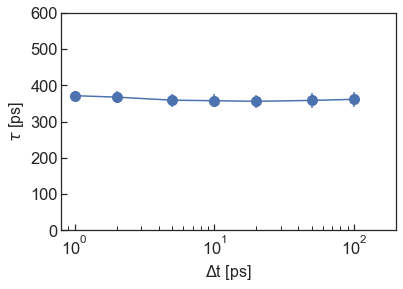

In [13]:
tau_vs_lagt = np.array([[x,msm_1D.msms[x].tauT[0],msm_1D.msms[x].tau_std[0]] \
               for x in sorted(msm_1D.msms.keys())])
fig, ax = plt.subplots()
ax.errorbar(tau_vs_lagt[:,0],tau_vs_lagt[:,1],fmt='o-', yerr=tau_vs_lagt[:,2], markersize=10)
#ax.fill_between(10**np.arange(-0.2,3,0.2), 1e-1, 10**np.arange(-0.2,3,0.2), facecolor='lightgray')
ax.set_xlabel(r'$\Delta$t [ps]', fontsize=16)
ax.set_ylabel(r'$\tau$ [ps]', fontsize=16)
ax.set_xlim(0.8,200)
ax.set_ylim(0,600)
_ = ax.set_xscale('log')

The relaxation times converge well as they are independent of the lag time.

/home/daviddesancho/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


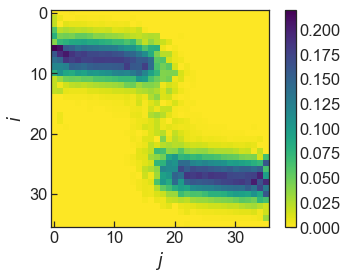

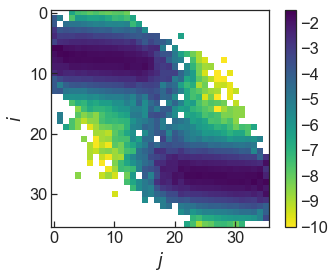

In [14]:
lt=2
plt.figure()
plt.imshow(msm_1D.msms[lt].trans, interpolation='none', \
    cmap='viridis_r')
plt.ylabel('$\it{i}$')
plt.xlabel('$\it{j}$')
plt.colorbar()
plt.figure()
plt.imshow(np.log(msm_1D.msms[lt].trans), interpolation='none', \
    cmap='viridis_r')
plt.ylabel('$\it{i}$')
plt.xlabel('$\it{j}$')
plt.colorbar()

Text(0,0.5,'$\\tau_i$ [ns]')

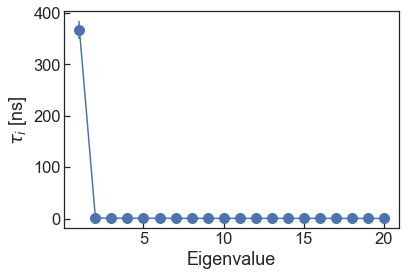

In [15]:
fig, ax = plt.subplots()
ax.errorbar(range(1,len(msm_1D.msms[lt].tauT)+1),msm_1D.msms[lt].tauT, fmt='o-', \
            yerr= msm_1D.msms[lt].tau_std, ms=10)
ax.set_xlabel('Eigenvalue')
ax.set_ylabel(r'$\tau_i$ [ns]')

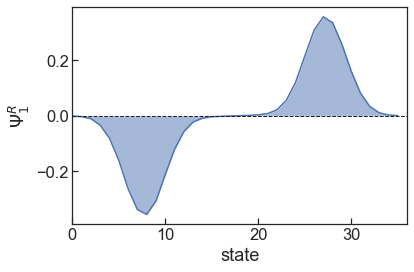

In [29]:
fig, ax = plt.subplots()
ax.plot(msm_1D.msms[2].rvecsT[:,1])
ax.set_xlabel("state")
ax.set_ylabel("$\Psi^R_1$")
ax.axhline(0,0,25, c='k', ls='--', lw=1)
ax.fill_between(range(len(msm_1D.msms[2].rvecsT[:,1])), msm_1D.msms[2].rvecsT[:,1], 0, alpha=0.5)
ax.set_xlim(0,36)
plt.show()

The slowest mode in our model, captured by the first eigenvector $\Psi^R_1$, corresponds to the transition betweem the folded and unfolded states of the protein.